# Pretrained ML models on Sentinel-2 Images

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
from sklearn import metrics
import os

In [3]:
path = os.getcwd()
path

'/home/jupyter/satellite'

In [12]:
# Choose the land classification level here
level = 3  # choose 1, 2 or 3

In [13]:
df = pd.read_csv('Level'+str(level)+'_labels.csv', header=None, sep='|')

In [14]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2)

data = ImageDataBunch.from_df(path,
                              df,
                              folder='../data/rgb',suffix='.png',
                              label_delim=';',
                              bs=256,
                              seed=42,
                              valid_pct=0.2,
                              ds_tfms=tfms,
                              size=120).normalize(imagenet_stats)

In [15]:
# Metrics
acc_02 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)

# Create cnn with the resnet50 architecture
learner = cnn_learner(data, models.resnet50, metrics=[acc_02,f_score])

In [16]:
learner.load('Level'+str(level)+'_stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (415472 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Non-irrigated arable land;Pastures;Complex cultivation patterns;Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leaved forest,Broad-leaved forest;Sclerophyllous vegetation;Transitional woodland/shrub,Discontinuous urban fabric;Land principally occupied by agriculture, with significant areas of natural vegetation;Broad-leaved forest,Pastures;Coniferous forest,Mixed forest;Water bodies
Path: /home/jupyter/satellite;

Valid: LabelList (103867 items)
x: ImageList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: MultiCategoryList
Mineral extraction sites;Pastures,Sea and ocean,Discontinuous urban fabric;Complex cultivation patterns;Land principally occupied by agriculture, with significant areas of na

In [10]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 60, 60]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 60, 60]         128        True      
______________________________________________________________________
ReLU                 [64, 60, 60]         0          False     
______________________________________________________________________
MaxPool2d            [64, 30, 30]         0          False     
______________________________________________________________________
Conv2d               [64, 30, 30]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 30, 30]         128        True      
______________________________________________________________________
Conv2d               [64, 30, 30]         36,864     True      
___________________________________________________

### Analysis

In [19]:
preds,y,losses = learner.get_preds(with_loss=True)

In [77]:
interp = ClassificationInterpretation(learner,preds,y,losses)

2148 misclassified samples over 103867 samples in the validation set.


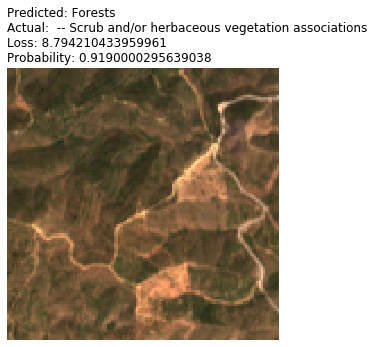

In [78]:
misclassifieds = interp.plot_multi_top_losses(5, figsize=(5,5), save_misclassified=True)
#interp.plot_multi_top_losses(10, figsize=(5,5))

2148 misclassified samples over 103867 samples in the validation set.


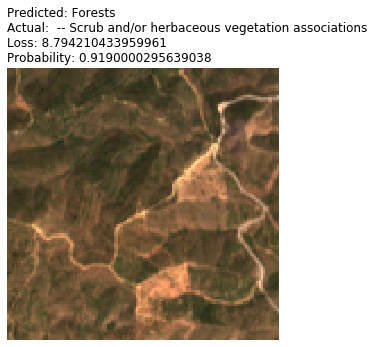

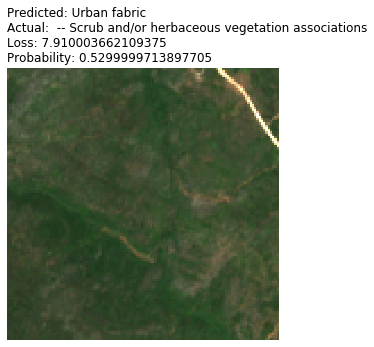

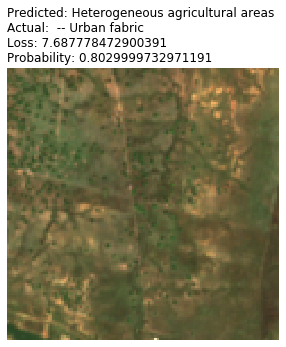

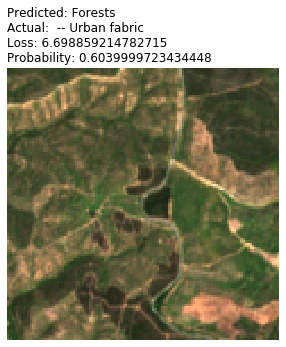

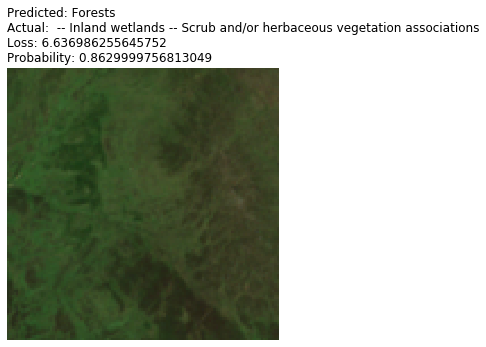

In [79]:
interp.plot_multi_top_losses(5, figsize=(5,5))

In [80]:
len(misclassifieds)

2148

In [18]:
data.classes

['Agro-forestry areas',
 'Airports',
 'Annual crops associated with permanent crops',
 'Bare rock',
 'Beaches, dunes, sands',
 'Broad-leaved forest',
 'Burnt areas',
 'Coastal lagoons',
 'Complex cultivation patterns',
 'Coniferous forest',
 'Construction sites',
 'Continuous urban fabric',
 'Discontinuous urban fabric',
 'Dump sites',
 'Estuaries',
 'Fruit trees and berry plantations',
 'Green urban areas',
 'Industrial or commercial units',
 'Inland marshes',
 'Intertidal flats',
 'Land principally occupied by agriculture, with significant areas of natural vegetation',
 'Mineral extraction sites',
 'Mixed forest',
 'Moors and heathland',
 'Natural grassland',
 'Non-irrigated arable land',
 'Olive groves',
 'Pastures',
 'Peatbogs',
 'Permanently irrigated land',
 'Port areas',
 'Rice fields',
 'Road and rail networks and associated land',
 'Salines',
 'Salt marshes',
 'Sclerophyllous vegetation',
 'Sea and ocean',
 'Sparsely vegetated areas',
 'Sport and leisure facilities',
 'Transit

In [82]:
learner.predict(misclassifieds[1])

(MultiCategory Urban fabric,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 tensor([1.4240e-02, 8.9984e-04, 1.5890e-01, 1.3228e-01, 1.2349e-03, 4.2228e-03,
         3.5433e-04, 1.8608e-04, 3.2175e-05, 1.5283e-02, 8.7932e-04, 7.9131e-03,
         1.1624e-01, 4.5398e-01, 5.2990e-01]))

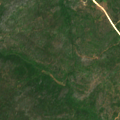

In [83]:
misclassifieds[1]

In [84]:
len(preds), len(y)

(103867, 103867)

In [85]:
preds[0]

tensor([2.1943e-01, 3.1596e-02, 4.3152e-01, 2.7371e-01, 1.2478e-01, 3.6164e-03,
        3.8459e-02, 4.5157e-04, 1.3433e-03, 6.0709e-02, 3.7345e-04, 9.9839e-01,
        2.4270e-04, 8.0874e-02, 5.4895e-01])

In [86]:
y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])

In [87]:
learner.validate()

[0.13179618, tensor(0.9431), tensor(0.8527)]

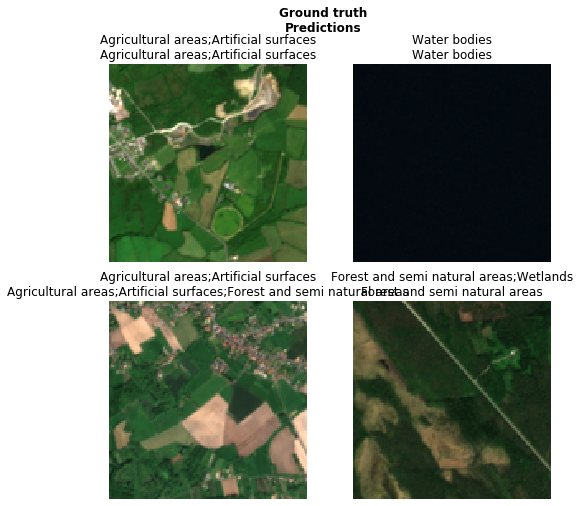

In [21]:
learner.show_results(rows=2)

In [113]:
filenames = data.valid_dl.items

In [114]:
valid_df = pd.DataFrame(list(zip(filenames, preds.squeeze().tolist(), y.squeeze().tolist())))

In [115]:
valid_df.head()

,0,1,2
0,/home/jupyter/satellite/../data/rgb/S2A_MSIL2A...,"[2.4647644750075415e-05, 7.886991807026789e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,/home/jupyter/satellite/../data/rgb/S2B_MSIL2A...,"[1.4966415606831873e-10, 2.4966296120320502e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/home/jupyter/satellite/../data/rgb/S2B_MSIL2A...,"[7.927634578663856e-05, 4.3153373553650454e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,/home/jupyter/satellite/../data/rgb/S2B_MSIL2A...,"[3.1084532565728296e-06, 1.9812518985418137e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,/home/jupyter/satellite/../data/rgb/S2A_MSIL2A...,"[0.4506722688674927, 0.00018679324421100318, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [116]:
valid_df['Predictions'] = [[round(c) for c in x] for x in valid_df[1]]

In [117]:
valid_df['Targets'] = [[round(c) for c in x] for x in valid_df[2]]

In [118]:
valid_df['Match']=(valid_df['Predictions']==valid_df['Targets'])

In [119]:
valid_df['Match'].value_counts()

False    69481
True     34386
Name: Match, dtype: int64

In [120]:
valid_df['Matches']=([valid_df['Predictions'][x]==valid_df['Targets'][x] for x in valid_df['Predictions']])

In [121]:
y_true = np.array(valid_df['Targets'].tolist())

In [122]:
y_pred = np.array(valid_df['Predictions'].tolist())

# Level 1 metrics

In [69]:
cm = metrics.multilabel_confusion_matrix(np.array(y_true.tolist()), np.array(y_pred.tolist()))
print(cm)
print(metrics.classification_report(np.array(y_true.tolist()), np.array(y_pred.tolist())))

[[[36692  2993]
  [ 4581 59601]]

 [[83964  2214]
  [ 5164 12525]]

 [[29781  3948]
  [ 3684 66454]]

 [[74011  1286]
  [ 2627 25943]]

 [[98608   390]
  [ 2700  2169]]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     64182
           1       0.85      0.71      0.77     17689
           2       0.94      0.95      0.95     70138
           3       0.95      0.91      0.93     28570
           4       0.85      0.45      0.58      4869

   micro avg       0.94      0.90      0.92    185448
   macro avg       0.91      0.79      0.83    185448
weighted avg       0.94      0.90      0.92    185448
 samples avg       0.95      0.92      0.92    185448



# Level 2 metrics

In [98]:
cm = metrics.multilabel_confusion_matrix(np.array(y_true.tolist()), np.array(y_pred.tolist()))
print(cm)
print(metrics.classification_report(np.array(y_true.tolist()), np.array(y_pred.tolist())))

[[[ 60064   5048]
  [  5893  32862]]

 [[102517     51]
  [  1153    146]]

 [[ 35299   4204]
  [  4047  60317]]

 [[ 54404   6792]
  [  9778  32893]]

 ...

 [[ 81283   2717]
  [  6498  13369]]

 [[ 98183    716]
  [  2840   2128]]

 [[ 65893   6154]
  [ 12941  18879]]

 [[ 86572   2177]
  [  4196  10922]]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     38755
           1       0.74      0.11      0.20      1299
           2       0.93      0.94      0.94     64364
           3       0.83      0.77      0.80     42671
           4       0.73      0.44      0.55      3050
           5       0.90      0.79      0.84     13542
           6       0.84      0.45      0.58      4424
           7       0.99      0.98      0.98     15083
           8       0.84      0.42      0.56       455
           9       0.81      0.16      0.26      1197
          10       0.74      0.44      0.55      1199
          11       0.83      0.67      0.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [106]:
cm[-6:]

array([[[102627,     43],
        [  1009,    188]],

       [[102487,    181],
        [   675,    524]],

       [[ 81283,   2717],
        [  6498,  13369]],

       [[ 98183,    716],
        [  2840,   2128]],

       [[ 65893,   6154],
        [ 12941,  18879]],

       [[ 86572,   2177],
        [  4196,  10922]]])

# Level 3 metrics

In [123]:
cm = metrics.multilabel_confusion_matrix(np.array(y_true.tolist()), np.array(y_pred.tolist()))
print(cm)
print(metrics.classification_report(np.array(y_true.tolist()), np.array(y_pred.tolist())))

[[[ 96681   1121]
  [  1428   4637]]

 [[103694      1]
  [   171      1]]

 [[102233    226]
  [  1045    363]]

 [[103214    104]
  [   263    286]]

 ...

 [[ 68466   5922]
  [ 13281  16198]]

 [[101836    142]
  [  1419    470]]

 [[ 91167    994]
  [  2770   8936]]

 [[101627    302]
  [   679   1259]]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      6065
           1       0.50      0.01      0.01       172
           2       0.62      0.26      0.36      1408
           3       0.73      0.52      0.61       549
           4       0.82      0.57      0.68       359
           5       0.80      0.72      0.76     28253
           6       0.00      0.00      0.00        72
           7       0.86      0.72      0.78       302
           8       0.75      0.64      0.69     20948
           9       0.86      0.86      0.86     32765
          10       0.00      0.00      0.00       247
          11       0.80      0.67      0.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
